# Importation des librairies

In [192]:
#import os
#cwd = os.getcwd()
#cwd

In [193]:
#!pip install openpyxl

In [194]:
#!pip install geopandas

In [195]:
# Pandas est une bibliothèque logicielle écrite pour le langage de programmation Python pour la manipulation et l'analyse de données.
import pandas as pd
# NumPy est une bibliothèque pour le langage de programmation Python, ajoutant la prise en charge de grands tableaux et matrices multidimensionnels, ainsi qu'une large collection de fonctions mathématiques de haut niveau pour opérer sur ces tableaux.
import numpy as np
# Matplotlib est une bibliothèque de traçage pour Python et pyplot nous offre un cadre de traçage de type MatLab. Nous l'utiliserons dans notre fonction de traceur pour tracer des données.
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
# Seaborn est une bibliothèque de visualisation de données Python basée sur matplotlib. Il fournit une interface de haut niveau pour dessiner des graphiques statistiques attrayants et informatifs
import seaborn as sns

# Importation des librairies pour la représentation cartographique
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from folium.plugins import MarkerCluster

# Importation de la table et analyse exploratoire

In [196]:
data_hydo = pd.read_excel('consommation-historique-region-administrative-11mars2024.xlsx')
df0 = pd.DataFrame(data_hydo)
df_conso = df0.copy()
df_conso['ANNEE_MOIS'] = pd.to_datetime(df_conso['ANNEE_MOIS'])
df_conso['ANNEE'], df_conso['MOIS'] = df_conso['ANNEE_MOIS'].dt.year, df_conso['ANNEE_MOIS'].dt.month
df_conso['ANNEE_MOIS'] = df_conso['ANNEE_MOIS'].dt.date.apply(lambda x: x.strftime('%Y-%m'))
df_conso.head()

,REGION_ADM_QC_TXT,ANNEE_MOIS,SECTEUR,Total (kWh),ANNEE,MOIS
0,Abitibi-Témiscamingue,2016-01,AGRICOLE,3.704146e+06,2016,1
1,Abitibi-Témiscamingue,2016-01,COMMERCIAL,5.455593e+07,2016,1
2,Abitibi-Témiscamingue,2016-01,INDUSTRIEL,3.153137e+08,2016,1
3,Abitibi-Témiscamingue,2016-01,INSTITUTIONNEL,3.128970e+07,2016,1
4,Abitibi-Témiscamingue,2016-01,RÉSIDENTIEL,1.756439e+08,2016,1


In [197]:
df_conso.shape

(8160, 6)

In [198]:
df_conso.isnull().sum()

REGION_ADM_QC_TXT       0
ANNEE_MOIS              0
SECTEUR                 0
Total (kWh)          1640
ANNEE                   0
MOIS                    0
dtype: int64

In [199]:
#Remplacement des valeurs na de la colonne Total (kWh) par 0
df_conso = df_conso.fillna(0)

In [200]:
df_conso.isnull().sum()

REGION_ADM_QC_TXT    0
ANNEE_MOIS           0
SECTEUR              0
Total (kWh)          0
ANNEE                0
MOIS                 0
dtype: int64

In [201]:
# Conversion de la colonne Total (kWh) en variable numérique
df_conso['Total (kWh)'] = df_conso['Total (kWh)'].astype(int)

In [202]:
df_conso.dtypes

REGION_ADM_QC_TXT    object
ANNEE_MOIS           object
SECTEUR              object
Total (kWh)           int32
ANNEE                 int32
MOIS                  int32
dtype: object

In [203]:
df_conso['REGION_ADM_QC_TXT'].unique()

array(['Abitibi-Témiscamingue', 'Bas-Saint-Laurent', 'Capitale-Nationale',
       'Centre-du-Québec', 'Chaudière-Appalaches', 'Côte-Nord', 'Estrie',
       'Gaspésie--Îles-de-la-Madeleine', 'Lanaudière', 'Laurentides',
       'Laval', 'Mauricie', 'Montréal', 'Montérégie', 'Nord-du-Québec',
       'Outaouais', 'Saguenay--Lac-Saint-Jean'], dtype=object)

In [204]:
df_conso['SECTEUR'].unique()

array(['AGRICOLE', 'COMMERCIAL', 'INDUSTRIEL', 'INSTITUTIONNEL',
       'RÉSIDENTIEL'], dtype=object)

# Analyse Descriptive

### A- Secteurs VS Consommation

#### Diagramme Circulaire

In [205]:
df_secteur= df_conso.groupby(['SECTEUR'])['Total (kWh)'].sum().reset_index().set_index('SECTEUR')
df_secteur.head()

,Total (kWh)
SECTEUR,
AGRICOLE,14079528140
COMMERCIAL,217960735425
INDUSTRIEL,432982965800
INSTITUTIONNEL,73716058162
RÉSIDENTIEL,459574931636


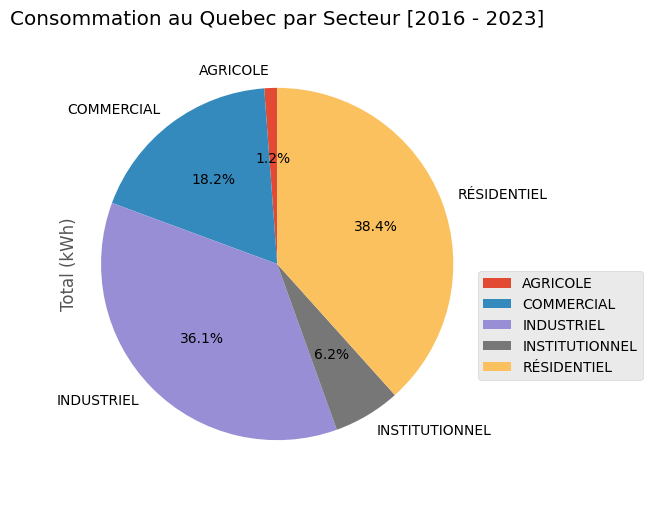

In [206]:
# Diagramme circulaire
df_secteur['Total (kWh)'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # ajouter des pourcentages
                            startangle=90,     # angle de départ 90°
                            )

plt.title('Consommation au Quebec par Secteur [2016 - 2023]')
plt.axis('equal') # Définit le diagramme circulaire pour qu'il ressemble à un cercle.
plt.legend(labels=df_secteur.index,loc='upper left', bbox_to_anchor=(1, 0.5))

plt.show()

__INTERPRETATION__ : Le secteur ayant la plus forte consommation est le secteur Résidentiel, suivi du secteur Industriel, Commercial, Institutionnel et enfin agricole.

#### Boites à moustache

In [207]:
df_secteur2_0 = df_conso.groupby(['SECTEUR', 'ANNEE'])['Total (kWh)'].sum().reset_index()
df_secteur2_1 = pd.crosstab(df_secteur2_0['ANNEE'], df_secteur2_0['SECTEUR'],values=df_secteur2_0['Total (kWh)'], aggfunc='sum')

In [208]:
df_secteur2_1.describe()

SECTEUR,AGRICOLE,COMMERCIAL,INDUSTRIEL,INSTITUTIONNEL,RÉSIDENTIEL
count,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00,8.000000e+00
mean,1.759941e+09,2.724509e+10,5.412287e+10,9.214507e+09,5.744687e+10
std,1.211716e+08,8.986697e+08,2.350727e+09,1.674841e+08,1.383633e+09
min,1.520304e+09,2.604075e+10,5.042930e+10,8.943404e+09,5.563772e+10
25%,1.719130e+09,2.650335e+10,5.287518e+10,9.138605e+09,5.639202e+10
50%,1.776117e+09,2.737310e+10,5.441055e+10,9.197065e+09,5.729990e+10
75%,1.827564e+09,2.808370e+10,5.580876e+10,9.297625e+09,5.867232e+10
max,1.903447e+09,2.817810e+10,5.731319e+10,9.493653e+09,5.923686e+10


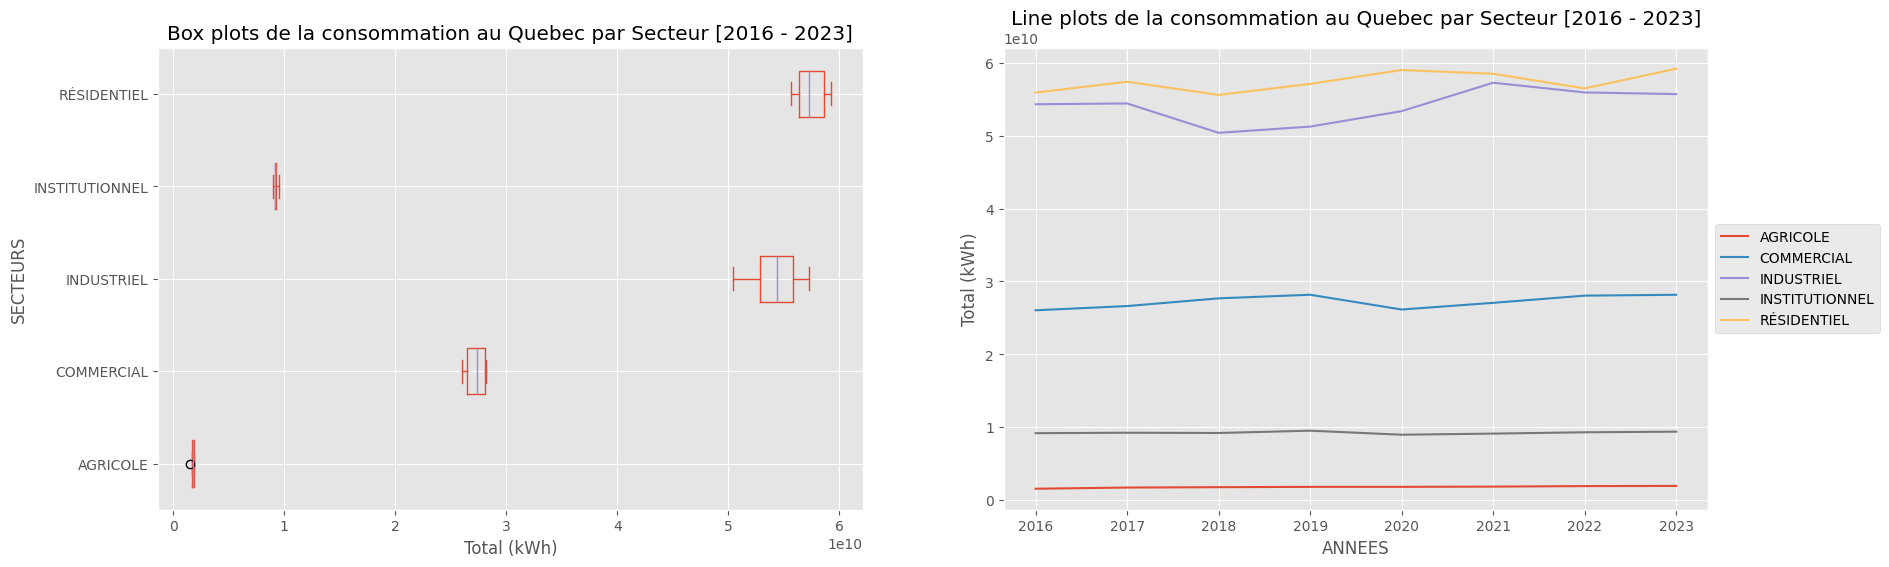

In [209]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
df_secteur2_1.plot(kind='box', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box plots de la consommation au Quebec par Secteur [2016 - 2023]')
ax0.set_xlabel('Total (kWh)')
ax0.set_ylabel('SECTEURS')

# Subplot 2: Line plot
df_secteur2_1.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line plots de la consommation au Quebec par Secteur [2016 - 2023]')
ax1.set_ylabel('Total (kWh)')
ax1.set_xlabel('ANNEES')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

__INTERPRETATION__ : 
> 1- Le secteur ayant la plus forte consommation est le secteur Résidentiel, suivi du secteur Industriel, Commercial, Institutionnel et enfin agricole.   
> 2- La consommation induite par le secteur résidentiel est telle que, de janvier 2016 à décembre 2023, la consommation moyenne de ce secteur (soit 5.910387e+10 kWh) a été supérieure au maximum de ce que le secteur industriel a consommé (soit 5.731319e+10 kWh).



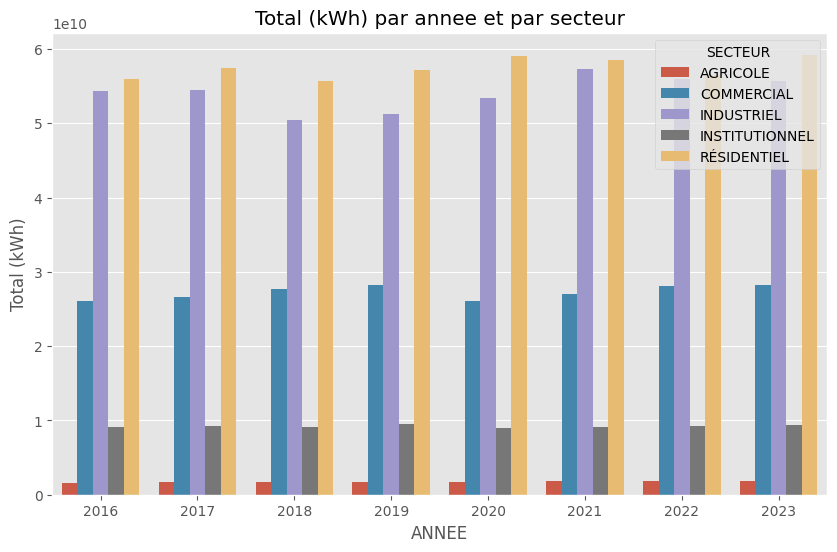

In [210]:
# Create the grouped bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='ANNEE', y='Total (kWh)', hue='SECTEUR', data=df_secteur2_0)
#plt.xticks(ticks=[0, 1], labels=['Non-Recession', 'Recession'])
plt.xlabel('ANNEE')
plt.ylabel('Total (kWh)')
plt.title('Total (kWh) par annee et par secteur')

plt.show()

### B- SECTEUR RESIDENTIEL VS Consommation

In [211]:
df_residentiel_annee = df_conso[df_conso['SECTEUR']=='RÉSIDENTIEL'].groupby(['ANNEE'])['Total (kWh)'].sum()
df_residentiel_annee_mois = df_conso[df_conso['SECTEUR']=='RÉSIDENTIEL'].groupby(['ANNEE_MOIS'], as_index=True )['Total (kWh)'].sum()

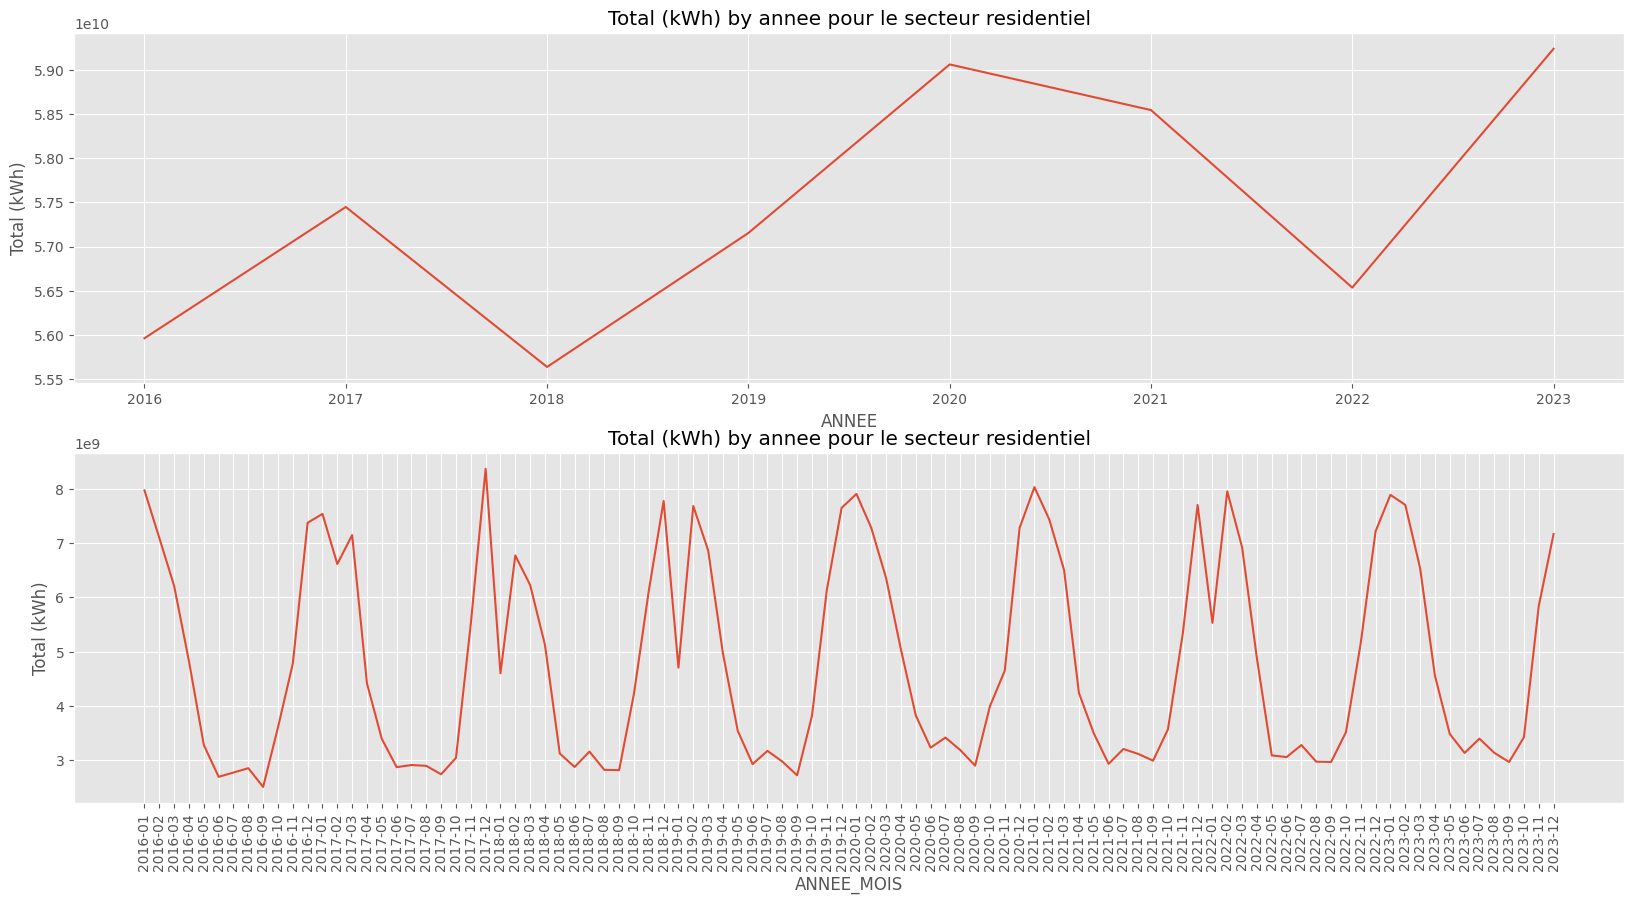

In [212]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(2, 1, 1) # add subplot 1 (2 row, 1 columns, first plot)
ax1 = fig.add_subplot(2, 1, 2) # add subplot 2 (2 row, 1 columns, second plot). 

# Subplot 1: Consommation résidentielle par année
df_residentiel_annee.plot(kind = 'line', figsize=(20, 10), ax=ax0) # add to subplot 1)
ax0.set_xlabel('ANNEE')
ax0.set_ylabel('Total (kWh)')
ax0.set_title('Total (kWh) by annee pour le secteur residentiel')


# Subplot 2: Consommation résidentielle par année-mois
df_residentiel_annee_mois.plot(kind = 'line', figsize=(20, 10), ax=ax1) # add to subplot 2
ax1.set_xticks(range(len(df_conso['ANNEE_MOIS'].unique())),df_residentiel_annee_mois.index,rotation = 90)
ax1.set_xlabel('ANNEE_MOIS')
ax1.set_ylabel('Total (kWh)')
ax1.set_title('Total (kWh) by annee pour le secteur residentiel')


plt.show()

__INTERPRETATION__ : 
> 1- Consommations annuelles élevées en 2018, 2019 et 2022.   
> 2- Par année, la consommation suit une variation saisonnière : très forte en hiver (décembre à mars), décroit durant le printemps et l'été (en particulier de mai à Septembre) puis recommence à croitre pour atteindre un nouveau pic en hiver.

## C- Données Météorologiques VS Consommation 

In [213]:
#Importation des données de météorologique sur la période de 2016 à 2023
df_meteo0 = pd.read_csv('climate-monthly.csv')
df_meteo = pd.DataFrame(df_meteo0)

In [214]:
df_meteo.isnull().sum()

x                               0
y                               0
NORMAL_SUNSHINE              4395
DAYS_WITH_VALID_SUNSHINE     5050
LOCAL_YEAR                      0
DAYS_WITH_VALID_MAX_TEMP        0
LATITUDE                        0
COOLING_DEGREE_DAYS          3525
NORMAL_SNOWFALL              2310
LOCAL_MONTH                     0
DAYS_WITH_VALID_MEAN_TEMP       0
LONGITUDE                       0
ID                              0
DAYS_WITH_VALID_PRECIP          0
MEAN_TEMPERATURE             3525
CLIMATE_IDENTIFIER              0
ENG_PROVINCE_NAME               0
LAST_UPDATED                    0
FRE_PROVINCE_NAME               0
MIN_TEMPERATURE                50
NORMAL_PRECIPITATION          861
TOTAL_SNOWFALL                429
LOCAL_DATE                      0
DAYS_WITH_VALID_MIN_TEMP        0
SNOW_ON_GROUND_LAST_DAY      1121
STATION_NAME                    0
BRIGHT_SUNSHINE              5146
TOTAL_PRECIPITATION           353
HEATING_DEGREE_DAYS          3525
MAX_TEMPERATUR

In [215]:
df_meteo_corr = df_meteo[['LOCAL_YEAR','LOCAL_MONTH',  
       'DAYS_WITH_VALID_MAX_TEMP', 
       'NORMAL_SNOWFALL',  'DAYS_WITH_VALID_MEAN_TEMP',
       'DAYS_WITH_VALID_PRECIP', 'MEAN_TEMPERATURE',
       'MIN_TEMPERATURE', 'NORMAL_PRECIPITATION',
       'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_MIN_TEMP',
       'SNOW_ON_GROUND_LAST_DAY',
       'TOTAL_PRECIPITATION', 'MAX_TEMPERATURE',
       'DAYS_WITH_PRECIP_GE_1MM', 'NORMAL_MEAN_TEMPERATURE',
       'DAYS_WITH_VALID_SNOWFALL']]
#df_meteo_corr = df_meteo_corr.fillna(0)
df_meteo_corr1 = df_meteo_corr.groupby(['LOCAL_YEAR','LOCAL_MONTH']).mean().reset_index()
df_meteo_corr1 = df_meteo_corr1.rename(columns={'LOCAL_YEAR': 'ANNEE', 'LOCAL_MONTH': 'MOIS'})
df_meteo_corr1.head(1)

,ANNEE,MOIS,DAYS_WITH_VALID_MAX_TEMP,NORMAL_SNOWFALL,DAYS_WITH_VALID_MEAN_TEMP,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,NORMAL_PRECIPITATION,TOTAL_SNOWFALL,DAYS_WITH_VALID_MIN_TEMP,SNOW_ON_GROUND_LAST_DAY,TOTAL_PRECIPITATION,MAX_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,NORMAL_MEAN_TEMPERATURE,DAYS_WITH_VALID_SNOWFALL
0,2016,1,23.308824,55.130727,19.544118,26.882353,-7.628851,-26.186567,77.256364,30.156061,22.014706,17.207547,42.722388,6.829412,9.686567,-11.465273,27.014706


In [216]:
df_conso_annee_mois = df_conso.groupby(['ANNEE', 'MOIS'])['Total (kWh)'].sum().reset_index()
merged_df = pd.merge(df_conso_annee_mois, df_meteo_corr1, on=['ANNEE', 'MOIS'], how='inner')
merged_df1 = merged_df.drop(columns=['ANNEE', 'MOIS'])
merged_df1.head(1)

,Total (kWh),DAYS_WITH_VALID_MAX_TEMP,NORMAL_SNOWFALL,DAYS_WITH_VALID_MEAN_TEMP,DAYS_WITH_VALID_PRECIP,MEAN_TEMPERATURE,MIN_TEMPERATURE,NORMAL_PRECIPITATION,TOTAL_SNOWFALL,DAYS_WITH_VALID_MIN_TEMP,SNOW_ON_GROUND_LAST_DAY,TOTAL_PRECIPITATION,MAX_TEMPERATURE,DAYS_WITH_PRECIP_GE_1MM,NORMAL_MEAN_TEMPERATURE,DAYS_WITH_VALID_SNOWFALL
0,16583784645,23.308824,55.130727,19.544118,26.882353,-7.628851,-26.186567,77.256364,30.156061,22.014706,17.207547,42.722388,6.829412,9.686567,-11.465273,27.014706


In [217]:
#Identification des variables les plus corrélées à Total (kWh)
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = merged_df.corr()
corr2 = corr[['Total (kWh)']][(corr > 0.8) | (corr < -0.8)].dropna(axis=0, how='all')
corr2.style.background_gradient(cmap='coolwarm')

,Total (kWh)
Total (kWh),1.000000
NORMAL_SNOWFALL,0.940735
MEAN_TEMPERATURE,-0.917684
MIN_TEMPERATURE,-0.916963
NORMAL_PRECIPITATION,-0.803187
TOTAL_SNOWFALL,0.849199
MAX_TEMPERATURE,-0.928217
NORMAL_MEAN_TEMPERATURE,-0.930714


__NOTE__ : 
> 1- Exclure NORMAL_SNOWFALL et TOTAL_SNOWFALL parce que l'unité de la variable est non identifiée  
> 2- NORMAL_MEAN_TEMPERATURE et MEAN_TEMPERATURE sont corrélés à 98%. On retient uniquement MEAN_TEMPERATURE 

__INTERPRETATION__ : 
> 1- Une baisse de la température entraine une augmentation de la consommation Total (kWh)   
> 2- Une augmentation de la température entraine une baisse de la consommation Total (kWh)

In [218]:
df_conso_vs_meteo = merged_df[['ANNEE','MOIS','Total (kWh)', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','MAX_TEMPERATURE']]
df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE'].astype(str) + '-' + df_conso_vs_meteo['MOIS'].astype(str)
df_conso_vs_meteo['ANNEE_MOIS'] = pd.to_datetime(df_conso_vs_meteo['ANNEE_MOIS'])
df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE_MOIS'].dt.date.apply(lambda x: x.strftime('%Y-%m'))

df_meteo_plot = df_conso_vs_meteo.drop(columns=['ANNEE', 'MOIS','Total (kWh)','MEAN_TEMPERATURE'])
#df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS']).mean().sort_values(by=['ANNEE_MOIS'])
df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS'], as_index=True).mean()

df_meteo_plot_annee = df_conso_vs_meteo.drop(columns=['ANNEE_MOIS', 'MOIS','Total (kWh)','MEAN_TEMPERATURE'])
#df_meteo_plot = df_meteo_plot.groupby(['ANNEE_MOIS']).mean().sort_values(by=['ANNEE_MOIS'])
df_meteo_plot_annee = df_meteo_plot_annee.groupby(['ANNEE'], as_index=True).mean()

C:\Users\Natasha\AppData\Local\Temp\ipykernel_22164\3217522310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conso_vs_meteo['ANNEE_MOIS'] = df_conso_vs_meteo['ANNEE'].astype(str) + '-' + df_conso_vs_meteo['MOIS'].astype(str)
C:\Users\Natasha\AppData\Local\Temp\ipykernel_22164\3217522310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conso_vs_meteo['ANNEE_MOIS'] = pd.to_datetime(df_conso_vs_meteo['ANNEE_MOIS'])
C:\Users\Natasha\AppData\Local\Temp\ipykernel_22164\3217522310.py:4: SettingWithC

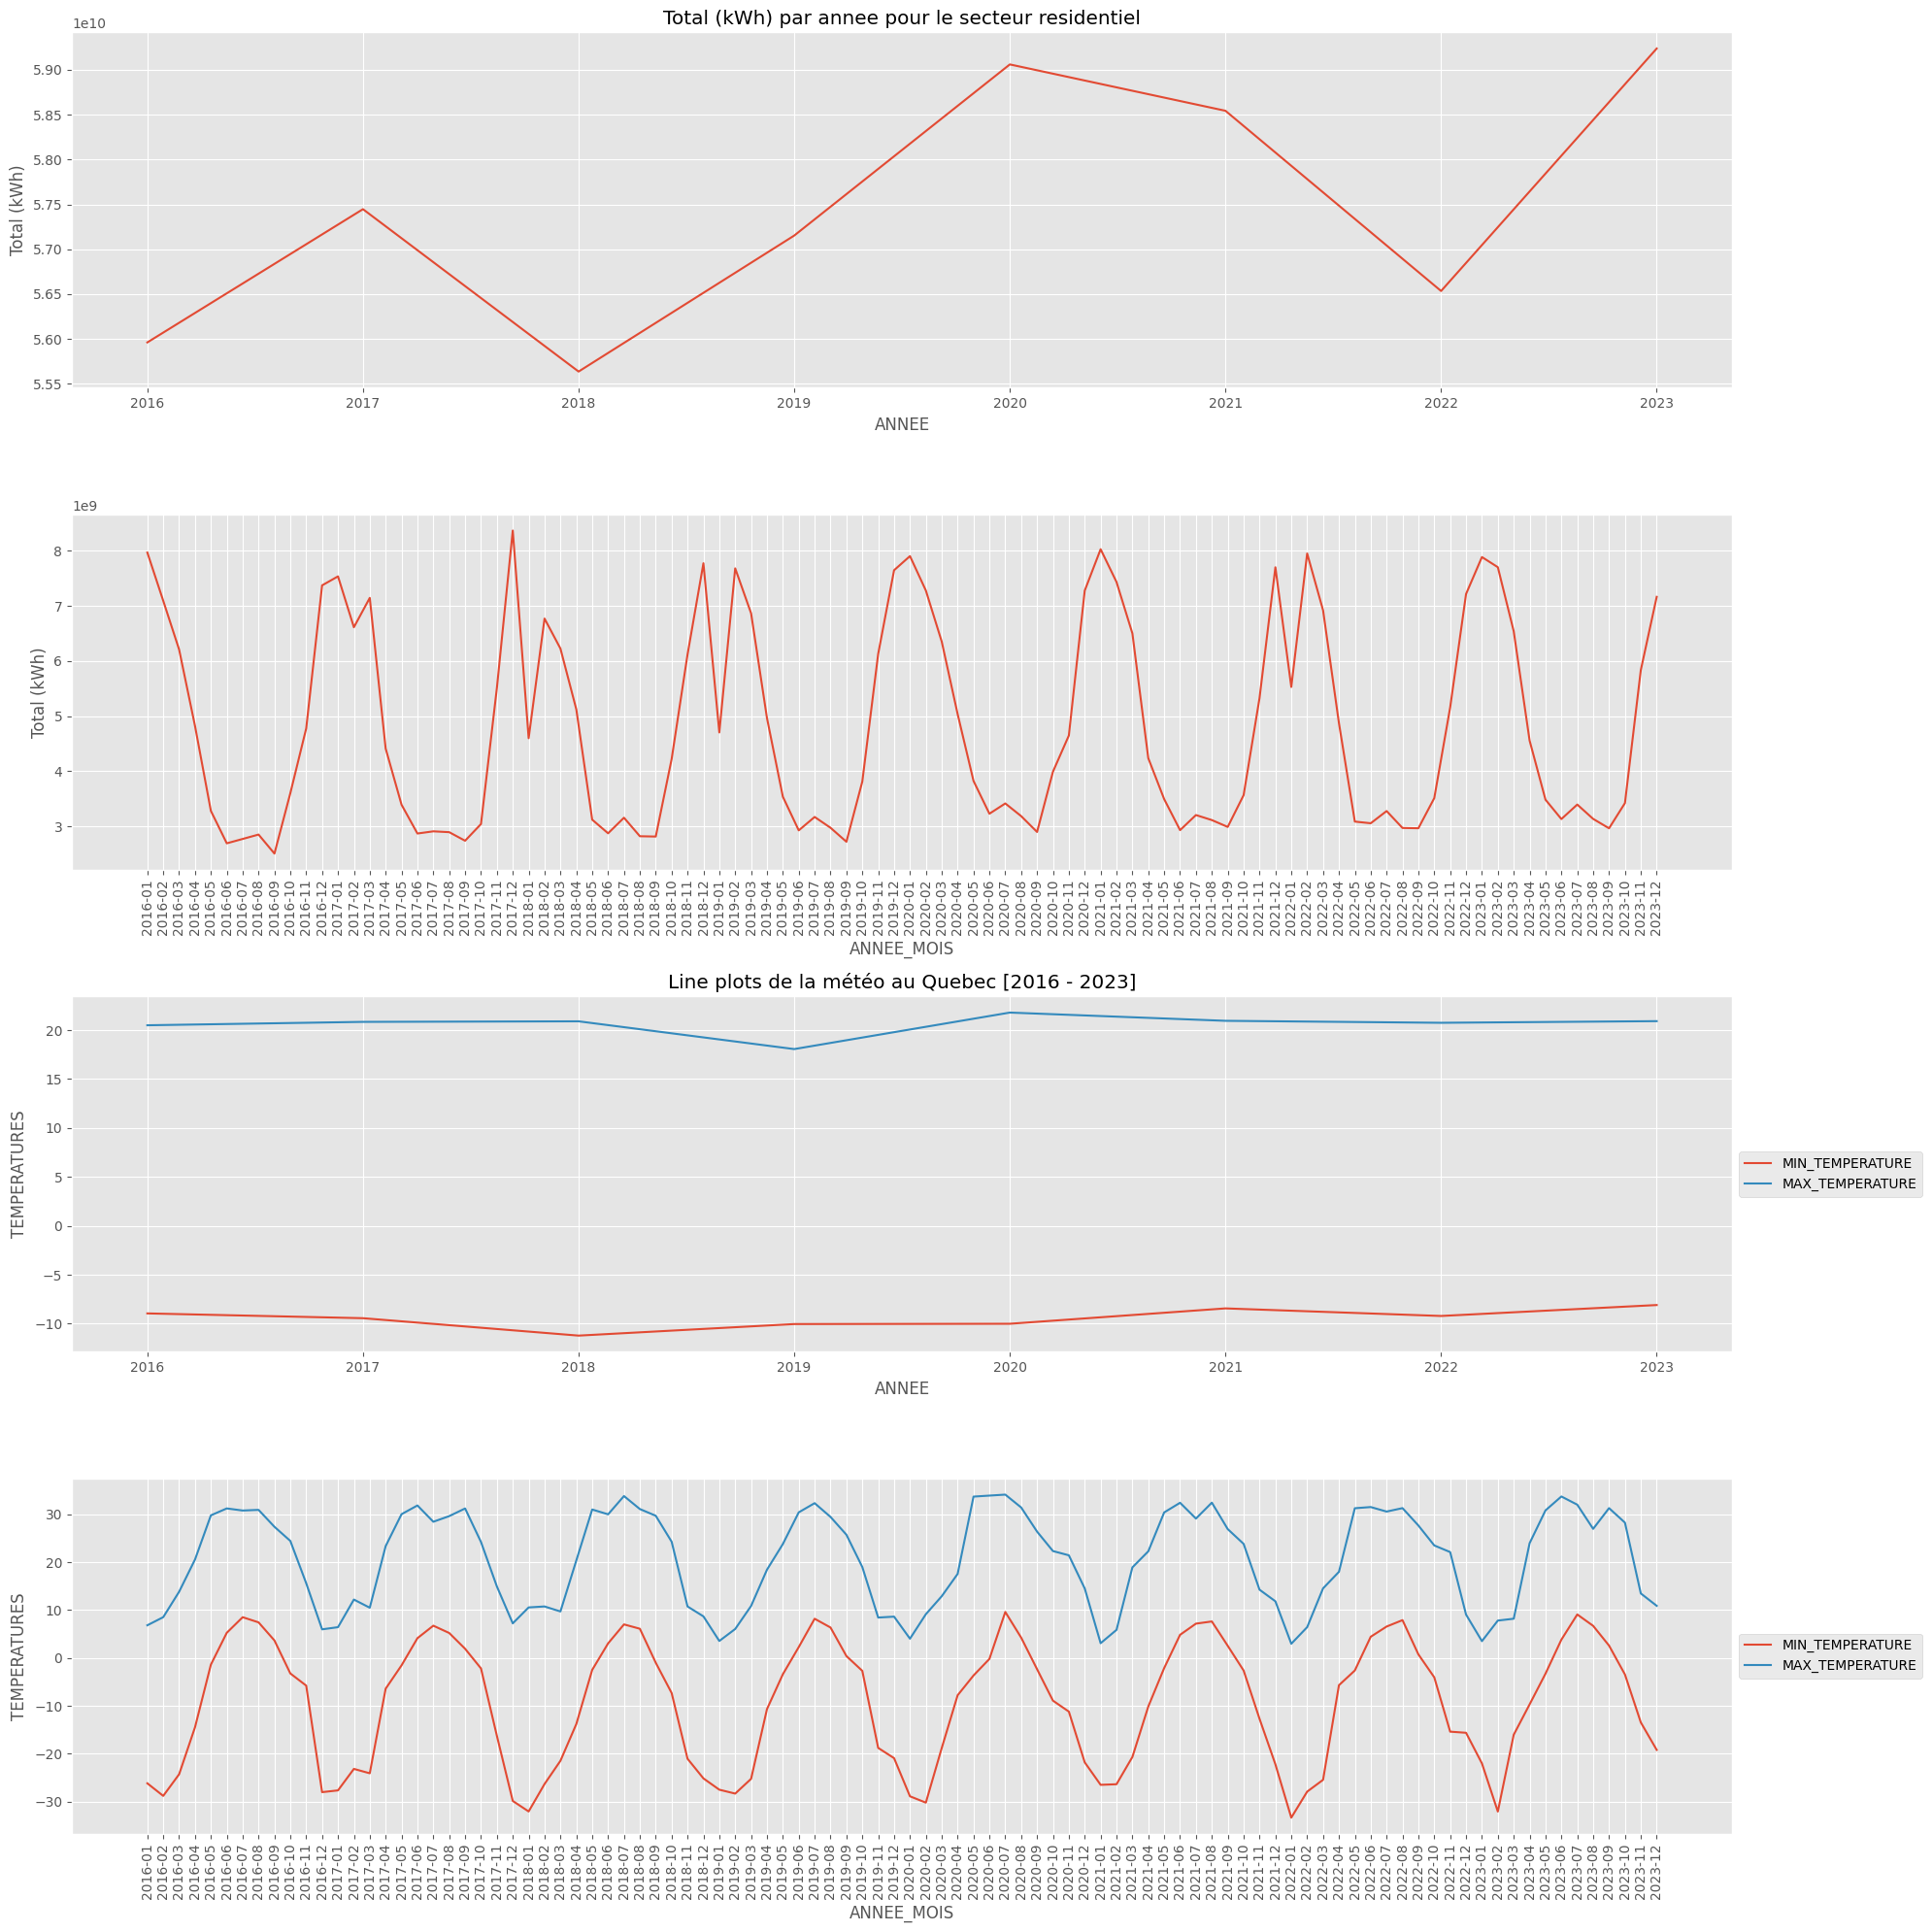

In [219]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(4, 1, 1) # add subplot 1 (4 row, 1 columns, first plot)
ax1 = fig.add_subplot(4, 1, 2) # add subplot 2 (4 row, 1 columns, second plot). 
ax2 = fig.add_subplot(4, 1, 3) # add subplot 2 (4 row, 1 columns, third plot). 
ax3 = fig.add_subplot(4, 1, 4) # add subplot 2 (4 row, 1 columns, fourth plot). 

# Subplot 1: Consommation résidentielle par année
df_residentiel_annee.plot(kind = 'line', figsize=(20, 20), ax=ax0) # add to subplot 1)
ax0.set_xlabel('ANNEE')
ax0.set_ylabel('Total (kWh)')
ax0.set_title('Total (kWh) par annee pour le secteur residentiel')

# Subplot 2: Consommation résidentielle par année-mois
df_residentiel_annee_mois.plot(kind = 'line', figsize=(20, 20), ax=ax1) # add to subplot 2
ax1.set_xticks(range(len(df_conso['ANNEE_MOIS'].unique())),df_residentiel_annee_mois.index,rotation = 90)
ax1.set_xlabel('ANNEE_MOIS')
ax1.set_ylabel('Total (kWh)')


df_meteo_plot_annee.plot(kind='line', figsize=(20, 20), ax=ax2) 
ax2.set_title ('Line plots de la météo au Quebec [2016 - 2023]')
ax2.set_ylabel('TEMPERATURES')
ax2.set_xlabel('ANNEE')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


df_meteo_plot.plot(kind='line', figsize=(20, 20), ax=ax3) # add to subplot 2
ax3.set_xticks(range(len(df_conso_vs_meteo['ANNEE_MOIS'].unique())),df_meteo_plot.index,rotation = 90)
ax3.set_ylabel('TEMPERATURES')
ax3.set_xlabel('ANNEE_MOIS')
ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
#plt.show()

In [220]:
df_meteo_plot_annee

,MIN_TEMPERATURE,MAX_TEMPERATURE
ANNEE,,
2016,-8.944667,20.495537
2017,-9.433261,20.842295
2018,-11.213103,20.898755
2019,-10.031769,18.062290
2020,-10.001565,21.792246
2021,-8.432045,20.950611
2022,-9.205745,20.748665
2023,-8.088694,20.915979


__INTERPRETATION__ :  Les années 2018, 2019 et 2022 qui présentaient des pics élevés de forte consommation sont marquées par des températures minimales moyennes les plus basses soient respectivement -12,54° , -12,14° et -12,19°

## Author

> Natacha Sessou  
> https://www.linkedin.com/in/sara-jelonek-578150162/

## Change Log

|Date (YYYY-MM-DD)|VersionChange| Description|
|-|-|-|
2024-04-29|0.1|Création du notebook|
